In [19]:
import pickle
import cv2, random, os
import scipy
import numpy as np
from scipy import spatial
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import torch

import detectron2
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

In [16]:
#parameters for Detectron net
MetadataCatalog.get("test_set").set(thing_classes=['fenster', 'haustuer', 'gaube', 'shop', 'dachfenster'])
train_metadata = MetadataCatalog.get("test_set")

In [21]:
# Reload the trained model
new_cfg = get_cfg()
if not torch.cuda.is_available():
    print('not using gpu acceleration')
    new_cfg.MODEL.DEVICE = 'cpu'

new_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
new_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5


new_cfg.MODEL.WEIGHTS = "train_mixed_b-400_LR0018_BS1024_MAXITER6339.pth" # path to the model we just trained
new_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85  # set a custom testing threshold
predictor = DefaultPredictor(new_cfg)

not using gpu acceleration


In [4]:
window_class = 0
gauben_class = 2
dachfenster_class = 4

In [5]:
## **Helper functions**

In [8]:
def dist_matrices(data):
    #find distances to other points (Euclidean)
    # output is matrix k*k
    distance_matrix = spatial.distance.cdist(data, data, 'euclidean')
    # find indexes of the closest points
    indexes = np.argsort(distance_matrix, axis=1)
    return distance_matrix, indexes

In [9]:
# calculate gradient: custom slope function
def CalcGrad(x1,y1,x2,y2):
    slope = (y2-y1)/(x2-x1)
    if slope == np.inf:
        slope = 0
    return slope

In [10]:
# Find the index of points which are inline
nPoints2Consider = 30 #optional

def CalcIndex(data,distance_matrix, indexes):    
    idx_of_hor_nbrs = []
    hor_grads = []
    for k in range(len(indexes)):
        neigbor_idx = indexes[k][:nPoints2Consider]  #indexes of n nearest neigbors
        neigbor = np.take(data, neigbor_idx, axis=0) # n nearest neigbors
        
        # for finding along curve take only n closest points (optional)
       # calculate gradient for the potential lines between those closest points
        
        gradients = [0] 
        for i in range(0,len(neigbor)-1):
            i+=1
            slope = CalcGrad(neigbor[0][0], neigbor[0][1],neigbor[i][0],neigbor[i][1]) #gradients for lines between point of interest and all other points
            gradients.append(slope)
        
        idx = [idx for j,idx in enumerate(neigbor_idx) if -0.035 <= gradients[j] <= 0.085] #threshold
        hor_slopes = [grads for j,grads in enumerate(gradients) if -0.035 <= gradients[j] <= 0.085] #threshold
        
        idx_of_hor_nbrs.append(idx)
        hor_grads.append(hor_slopes)
    
    return idx_of_hor_nbrs,hor_grads

In [11]:
#Function to combine point in horizontal groups based on gradients
def combine_lists(lists):
    # Keep a set of processed items
    skip = set()

    for i, a in enumerate(lists): 
        # If we already used this list, skip it
        if i in skip:
            continue

        for j, b in enumerate(lists[i + 1:], i + 1): 
            # Use a set to check if there are common numbers
            if set(a) & set(b):
                skip.add(j) # if there are common numbers in two sublist, j will be addes to a set of processed item

                for x in b: #element in sublist b
                    if x not in a:
                        a.append(x) #element from sublist b will be added to sublist a

    # yield all lists that were not added to different lists
    for i, a in enumerate(lists):
        if i not in skip: 
            yield a 

In [12]:
# Find number of floors. Output is a dictionary, e.g. {'snapshot':3}
def floor_count(image_name, predictor): # img_name als string
    im = cv2.imread(image_name)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    bbox = outputs['instances'][outputs['instances'].pred_classes==0].pred_boxes #choose only bboxes for class 0 (fenster)

    # get x,y-coordinates of centroids of each bbox
    box_cent = bbox.get_centers()
    box_cent = box_cent.cpu().numpy()

    #sort centroids by y-coordinates
    box_cent = box_cent[box_cent[:,1].argsort()]
    # get row indexes as a 3d column - 
    data = np.c_[box_cent,0:len(box_cent)]
    x = data[:,0]
    y = data[:,1]
    
    #find distance matrices and indexes
    distance_matrix, indexes = dist_matrices(data)
    
    #Find the index of points which are inline and gradient values
    idx_of_hor_nbrs,hor_grads = CalcIndex(data,distance_matrix, indexes)
    
    #return dict with number of floors
    if 2 in outputs['instances'].pred_classes or 4 in outputs['instances'].pred_classes: # 4=='gaube', 2=='dachfenster'
        floor_count = str(len(list(combine_lists(idx_of_hor_nbrs))))+' + DG'
    else:
        floor_count = str(len(list(combine_lists(idx_of_hor_nbrs))))
    return floor_count

In [13]:
#Visualisation of prediction
def vis_pred(image_name, predictor, train_metadata):
    im = cv2.imread(image_name)
    prediction = predictor(im)
    fig, ax = plt.subplots()
    im = ax.imshow(im)
    bbox = prediction['instances'][prediction['instances'].pred_classes==0].pred_boxes
    # get x,y-coordinates of centroids of each bbox
    box_cent = bbox.get_centers()
    box_cent = box_cent.cpu().numpy()
    #sort centroids by y-coordinates
    box_cent = box_cent[box_cent[:,1].argsort()]
    # get row indexes as a column
    data = np.c_[box_cent,0:len(box_cent)]
    #find distance matrices and indexes
    distance_matrix, indexes = dist_matrices(data)
    #Find the index of points which are inline and gradient values
    idx_of_hor_nbrs,hor_grads = CalcIndex(data,distance_matrix, indexes)
    lines = list(combine_lists(idx_of_hor_nbrs))
    colors = ["red", "blue", "green", "orchid", "yellow", "magenta", "cyan", "pink", "navy",
            "olive", "coral", "sienna", "salmon", "orchid", "aqua", "blue", "red", "green", "orchid"]
    for i,line in enumerate(lines):
        x_first = data[line[0],0]
        y_first = data[line[0],1]
        x_last = data[line[-1],0]
        y_last = data[line[-1],1]
        if len(line) == 1:
            x_last = x_first + 10
            y_last = y_first + 10
        plt.plot([x_first,x_last],[y_first,y_last], color=colors[i], linewidth=5)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.show()

## **Prediction**

In [14]:
# image filepath
test_img_folder = 'test-imgs/'
imgfilepath = test_img_folder + 'OLD1.jpg'

In [22]:
# predict
number_of_floors = floor_count(imgfilepath, predictor)
print("Number of floors is: ",number_of_floors)

/opt/homebrew/Caskroom/miniconda/base/envs/parkplatz/lib/python3.10/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1684998573547/work/aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Number of floors is:  7 + DG


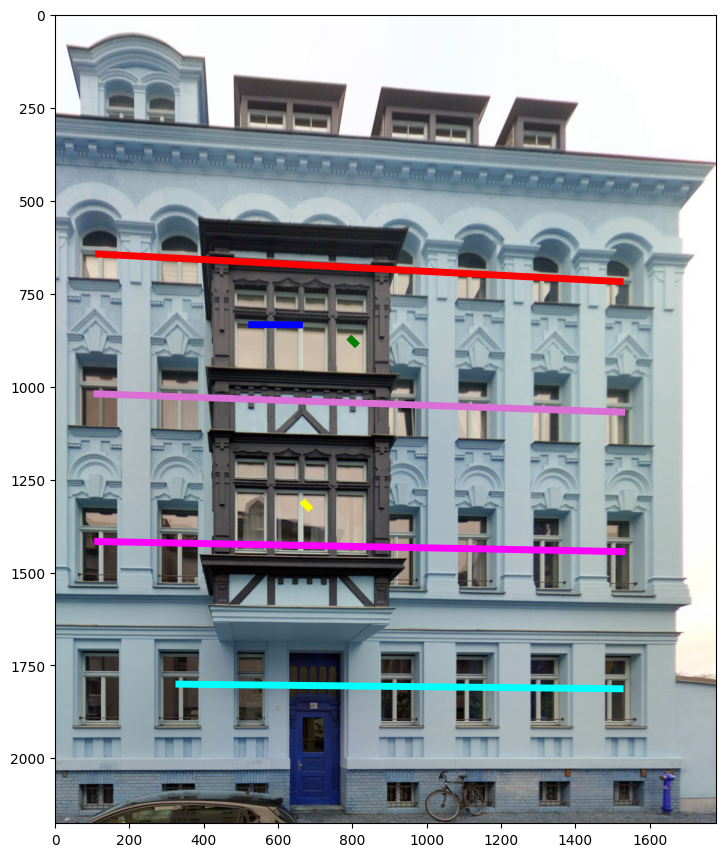

In [23]:
# visualize
vis_pred(imgfilepath, predictor, train_metadata)